In [36]:
import bt
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True

def above_sma(tickers, sma_per=50, start='2019-01-01', name='above_sma'):
    """
    Long securities that are above their n period
    Simple Moving Averages with equal weights.
    """
    # download data
    data = bt.get(tickers, start=start)
    # calc sma
    sma = data.rolling(sma_per).mean()
    # 选择价格在其移动平均线和120%移动平均线之间的证券
    between_sma_and_120_sma = (data > sma) & (data < 1.2 * sma)

    # create strategy
    s = bt.Strategy(name, [SelectWhere(between_sma_and_120_sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

    # now we create the backtest
    return bt.Backtest(s, data)
    

In [37]:
# simple backtest to test long-only allocation
def long_only_ew(tickers, start='2019-01-01', name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = bt.get(tickers, start=start)
    return bt.Backtest(s, data)

# create the backtests
tickers = 'rsp,iwy,moat,pff,vnq'
sma10 = above_sma(tickers, sma_per=10, name='sma10')
sma100 = above_sma(tickers, sma_per=100, name='sma100')
sma200 = above_sma(tickers, sma_per=200, name='sma200')
benchmark = long_only_ew('iwy', name='iwy')

resma10 = bt.run(sma10)

# run all the backtests!
res2 = bt.run(sma10, sma100, sma200, benchmark)

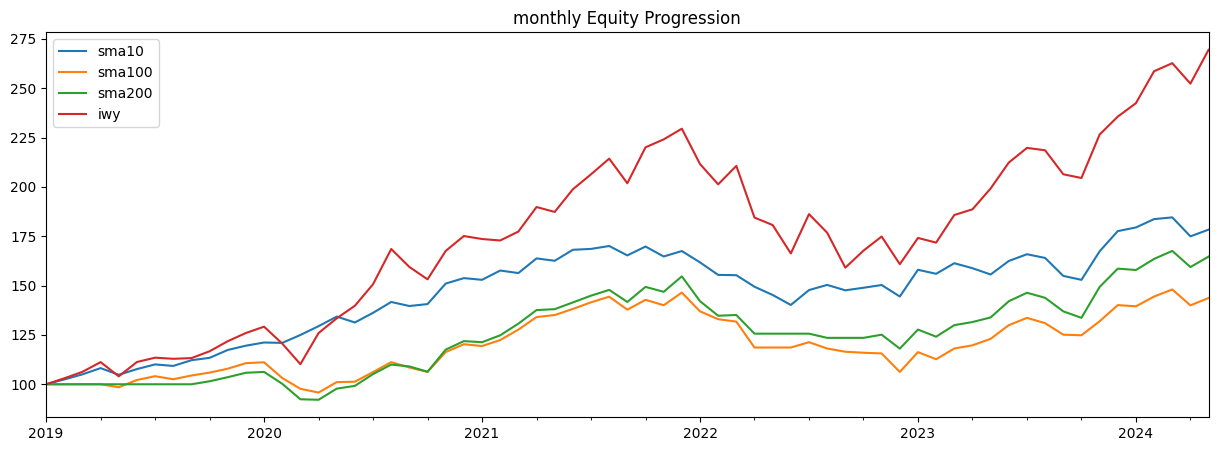

In [38]:
res2.plot(freq='m');

In [39]:
res2.display()

Stat                 sma10       sma100      sma200      iwy
-------------------  ----------  ----------  ----------  ----------
Start                2019-01-01  2019-01-01  2019-01-01  2019-01-01
End                  2024-06-21  2024-06-21  2024-06-21  2024-06-21
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         90.87%      46.02%      67.68%      212.34%
Daily Sharpe         0.97        0.62        0.80        1.01
Daily Sortino        1.52        0.91        1.19        1.61
CAGR                 12.54%      7.17%       9.91%       23.15%
Max Drawdown         -19.31%     -27.57%     -24.52%     -32.68%
Calmar Ratio         0.65        0.26        0.40        0.71

MTD                  2.94%       1.61%       1.81%       7.08%
3m                   -0.65%      -1.13%      0.29%       9.10%
6m                   3.94%       4.79%       6.30%       22.63%
YTD                  3.38%       4.22%       5.73%       22.47%
1Y                   13.99%      14.

In [35]:
# 获取交易明细
transactions = resma10.get_transactions()
print("\n交易明细:")
print(transactions)
transactions.to_csv("交易明细3.csv")


交易明细:
                          price  quantity
Date       Security                      
2019-01-15 iwy        71.548065    1397.0
           moat       40.665859    2459.0
           pff        26.529238    3769.0
           rsp        87.554916    1142.0
           vnq        64.474800    1550.0
...                         ...       ...
2024-06-21 iwy       214.119995    -436.0
           moat       87.029999    2177.0
           pff        31.570000    6033.0
           rsp       165.589996    -576.0
           vnq        83.970001   -1144.0

[5198 rows x 2 columns]
